In [1]:
%reload_ext autoreload
%autoreload 2
import sys
sys.path.append('../')
import os
os.environ['PYOPENGL_PLATFORM'] = 'egl'

import cv2
import time
import torch
import joblib
import shutil
import colorsys
import argparse
import numpy as np
from tqdm import tqdm
from multi_person_tracker import MPT
from torch.utils.data import DataLoader

from lib.models.vibe import VIBE_Demo
from lib.utils.renderer import Renderer
from lib.dataset.inference import Inference
from lib.utils.smooth_pose import smooth_pose
from lib.data_utils.kp_utils import convert_kps
from lib.utils.pose_tracker import run_posetracker

from lib.utils.demo_utils import (
    download_youtube_clip,
    smplify_runner,
    convert_crop_coords_to_orig_img,
    convert_crop_cam_to_orig_img,
    prepare_rendering_results,
    video_to_images,
    images_to_video,
    download_ckpt,
)

import matplotlib.pyplot as plt
import ml_collections
MIN_NUM_FRAMES = 25

In [2]:
video_file = '/home/epinyoan/dataset/casia-b/dataset_b/Datset-B-1/video/052-nm-03-144.avi'
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
image_folder, num_frames, img_shape = video_to_images(video_file, return_info=True)
print(f'Input video number of frames {num_frames}')
orig_height, orig_width = img_shape[:2]

# run multi object tracker
mot = MPT(
    device=device,
    batch_size=12,
    display=False,
    detector_type='yolo',
    output_format='dict',
    yolo_img_size=416,
)
tracking_results = mot(image_folder)
# ========= Define VIBE model ========= #
model = VIBE_Demo(
    seqlen=16,
    n_layers=2,
    hidden_size=1024,
    add_linear=True,
    use_residual=True,
).to(device)

# ========= Load pretrained weights ========= #
pretrained_file = download_ckpt(use_3dpw=True)
ckpt = torch.load(pretrained_file)
model.load_state_dict(ckpt['gen_state_dict'], strict=False)
model.eval()
print(f'Loaded pretrained weights from \"{pretrained_file}\"')

person_id = list(tracking_results.keys())[0]
bboxes = tracking_results[person_id]['bbox']
frames = tracking_results[person_id]['frames']
dataset = Inference(
    image_folder=image_folder,
    frames=frames,
    bboxes=bboxes,
    joints2d=None,
    scale=1.1,
)
bboxes = dataset.bboxes
frames = dataset.frames
dataloader = DataLoader(dataset, batch_size=450, num_workers=16)
with torch.no_grad():
    for batch in dataloader:
        batch = batch.unsqueeze(0)
        batch = batch.to(device)
        batch_size, seqlen = batch.shape[:2]
        output = model(batch)[-1]
        
pred_cam, pred_verts, pred_pose, pred_betas, pred_joints3d, smpl_joints2d, norm_joints2d = [], [], [], [], [], [], []
pred_cam.append(output['theta'][:, :, :3].reshape(batch_size * seqlen, -1))
pred_cam = torch.cat(pred_cam, dim=0)
pred_cam = pred_cam.cpu().numpy()
orig_cam = convert_crop_cam_to_orig_img(
    cam=pred_cam,
    bbox=bboxes,
    img_width=orig_width,
    img_height=orig_height
)


Running "ffmpeg -i /home/epinyoan/dataset/casia-b/dataset_b/Datset-B-1/video/052-nm-03-144.avi -f image2 -v error ./output/sample_video/052-nm-03-144_avi/%06d.png"
Images saved to "./output/sample_video/052-nm-03-144_avi"
Input video number of frames 101
Running Multi-Person-Tracker


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  4.85it/s]


Finished. Detection + Tracking FPS 54.29
=> loaded pretrained model from 'data/vibe_data/spin_model_checkpoint.pth.tar'
Loaded pretrained weights from "data/vibe_data/vibe_model_w_3dpw.pth.tar"


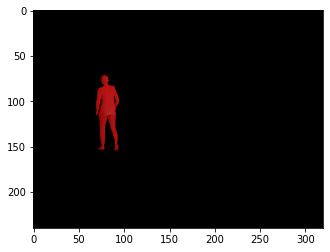

In [5]:
frame = 70
verts_ = output['verts'].reshape(batch_size * seqlen, -1, 3)
renderer = Renderer(resolution=(orig_width, orig_height), orig_img=True, wireframe=False)
img = renderer.render( # need to change output to mask for jupyter
    np.zeros((240, 320, 3)),
    verts_[frame].cpu().numpy(),
    cam=orig_cam[frame],
    color=[1,0,0],
    mesh_filename=None,
)
# img.astype(np.int).squeeze(axis=2)
plt.imshow(img)

### Pytorch 3D

In [6]:
import os
import torch
import matplotlib.pyplot as plt

from pytorch3d.utils import ico_sphere
import numpy as np
from tqdm.notebook import tqdm

# Util function for loading meshes
from pytorch3d.io import load_objs_as_meshes, save_obj

from pytorch3d.loss import (
    chamfer_distance, 
    mesh_edge_loss, 
    mesh_laplacian_smoothing, 
    mesh_normal_consistency,
)

# Data structures and functions for rendering
from pytorch3d.structures import Meshes
from pytorch3d.renderer import (
    look_at_view_transform,
    OpenGLPerspectiveCameras, 
    FoVPerspectiveCameras,
    FoVOrthographicCameras,
    PointLights, 
    DirectionalLights, 
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    SoftPhongShader,
    SoftSilhouetteShader,
    SoftPhongShader,
    TexturesVertex
)

# add path for demo utils functions 
import sys
import os
sys.path.append(os.path.abspath(''))
from plot_image_grid import image_grid
from pytorch3d.structures import Meshes
from lib.models.smpl import get_smpl_faces

In [7]:
faces = get_smpl_faces()
faces.shape

(13776, 3)

In [8]:
vert = verts_[19:20]
face = torch.tensor(np.expand_dims(faces, axis=0).astype(np.float32)).to(device)
vert.shape, face.shape

(torch.Size([1, 6890, 3]), torch.Size([1, 13776, 3]))

In [9]:
verts_rgb = torch.ones_like(vert) # (1, V, 3)
textures = TexturesVertex(verts_features=verts_rgb.to(device))
mesh = Meshes(vert, face, textures)

### SMPL

In [10]:
num_views = 20
elev = torch.linspace(0, 360, num_views)
azim = torch.linspace(-180, 180, num_views)
lights = PointLights(device=device, location=[[0.0, 0.0, -3.0]])
R, T = look_at_view_transform(dist=2.7, elev=elev, azim=azim)
cameras = OpenGLPerspectiveCameras(device=device, R=R, T=T)
camera = OpenGLPerspectiveCameras(device=device, R=R[None, 1, ...], 
                                  T=T[None, 1, ...]) 
raster_settings = RasterizationSettings(
    image_size=128, 
    blur_radius=0.0, 
    faces_per_pixel=1, 
)
renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=camera, 
        raster_settings=raster_settings
    ),
    shader=SoftPhongShader(
        device=device, 
        cameras=camera,
        lights=lights
    )
)
meshes = mesh.extend(num_views)
target_images = renderer(meshes, cameras=cameras, lights=lights)
# target_rgb = [target_images[i, ..., :3] for i in range(num_views)]
# target_cameras = [OpenGLPerspectiveCameras(device=device, R=R[None, i, ...], 
#                                            T=T[None, i, ...]) for i in range(num_views)]

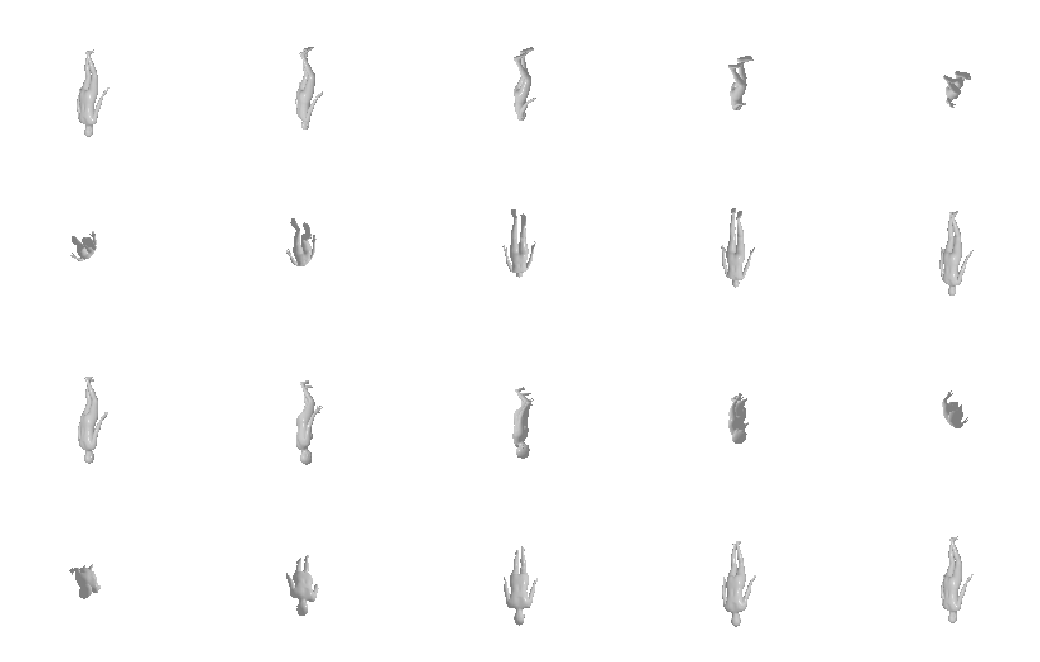

In [11]:
image_grid(target_images.cpu().numpy(), rows=4, cols=5, rgb=True)
plt.show()

### SMPL silhouette

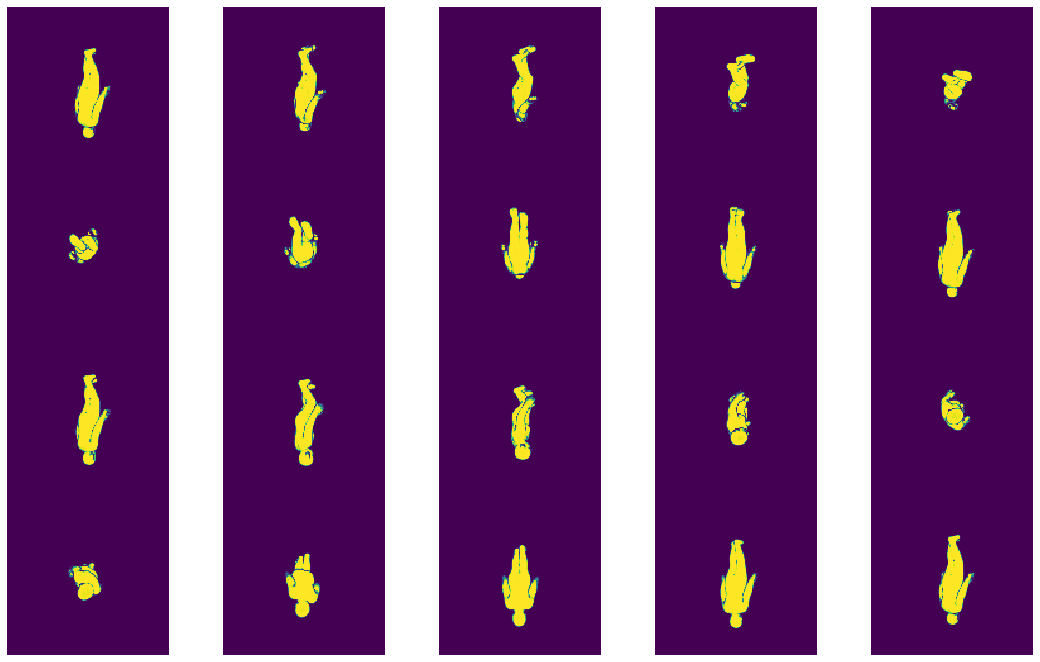

In [12]:
# Rasterization settings for silhouette rendering  
sigma = 1e-4
raster_settings_silhouette = RasterizationSettings(
    image_size=128, 
    blur_radius=np.log(1. / 1e-4 - 1.)*sigma, 
    faces_per_pixel=50, 
)

# Silhouette renderer 
renderer_silhouette = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=camera, 
        raster_settings=raster_settings_silhouette
    ),
    shader=SoftSilhouetteShader()
)

# Render silhouette images.  The 3rd channel of the rendering output is 
# the alpha/silhouette channel
silhouette_images = renderer_silhouette(meshes, cameras=cameras, lights=lights)
target_silhouette = [silhouette_images[i, ..., 3] for i in range(num_views)]

# Visualize silhouette images
image_grid(silhouette_images.cpu().numpy(), rows=4, cols=5, rgb=False)
plt.show()

### Single SMPL silhouette

In [57]:
from pytorch3d.renderer import OrthographicCameras

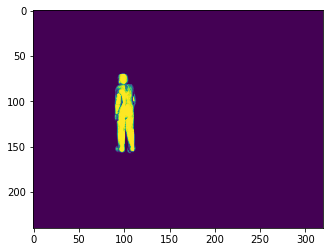

In [61]:
frame = 70
sx, sy, tx, ty = orig_cam[frame]
faces = get_smpl_faces()
vert = verts_[frame:frame+1].clone()

face = torch.tensor(np.expand_dims(faces, axis=0).astype(np.float32)).to(device)
verts_rgb = torch.ones_like(vert) # (1, V, 3)
textures = TexturesVertex(verts_features=verts_rgb.to(device))
mesh = Meshes(vert, face, textures)
sigma = 1e-4
lights = PointLights(device=device, location=[[0.0, 0.0, -3.0]])
camera = FoVOrthographicCameras(device=device, T=[[tx,ty,1]], scale_xyz=[[sx,sy,1]]) # , R=[renderer.Rx[:3,:3]] 
raster_settings_silhouette = RasterizationSettings(
    image_size=(orig_height,orig_width), 
    blur_radius=np.log(1. / 1e-4 - 1.)*sigma, 
    faces_per_pixel=50, 
)
renderer_silhouette = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=camera, 
        raster_settings=raster_settings_silhouette
    ),
    shader=SoftSilhouetteShader()
)
silhouette_images = renderer_silhouette(mesh, cameras=camera, lights=lights)
silhouette_images = torch.flip(silhouette_images, (1,2))
img = silhouette_images[0,...,3].cpu().numpy()
plt.imshow(img)

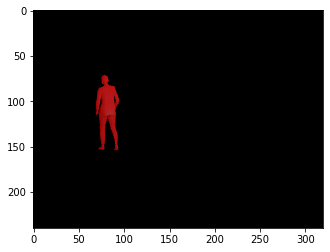

In [54]:
frame = 70
renderer = Renderer(resolution=(orig_width, orig_height), orig_img=True, wireframe=False)
img = renderer.render( # need to change output to mask for jupyter
    np.zeros((240, 320, 3)),
    verts_[frame].cpu().numpy(),
    cam=orig_cam[frame],
    color=[1,0,0],
    mesh_filename=None,
)

plt.imshow(img)